<a href="https://colab.research.google.com/github/pumazzo/ML-ISS2024/blob/main/Lezione_4_Shap_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pylab as pl
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
!pip install shap
import shap

# print the JS visualization code to the notebook
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt


Attribute Information:
  - age  =   age in years
  - sex
  - bmi  =   body mass index
  - bp   =   average blood pressure
  - s1   =   tc, total serum cholesterol
  - s2   =   ldl, low-density lipoproteins
  - s3   =   hdl, high-density lipoproteins
  - s4   =   tch, total cholesterol / HDL
  - s5   =   ltg, possibly log of serum triglycerides level
  - s6   =   glu, blood sugar level

In [3]:
X, y = shap.datasets.diabetes()
y = y/350
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, test_size=0.25, random_state=17)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
d_vali = xgboost.DMatrix(X_vali, label=y_vali)

In [4]:
print("train size : ",X_train.shape)
print("test size : ",X_test.shape)
print("vali size : ",X_vali.shape)

train size :  (264, 10)
test size :  (89, 10)
vali size :  (89, 10)


In [120]:
# n_estimators = 1 ---> decision tree
# max_leaves = 2 ----> linear classifier
params = {
    "tree_method": "hist",
    "booster" : "gbtree",# dart,gbtree # dart non supportato da shap

    "max_bin" :  128,
    "learning_rate": 0.05,# also called  eta
    "objective": "reg:squarederror",# loss

    "base_score": np.mean(y_train),#The initial prediction score of all instances, average is a good one for regression tasks
    "gamma" : 0.1,# regularization (pruning)
    "max_depth": 5, #Maximum depth of a tree. leaf is min_split_loss or max_depth # large to overfit
    "min_child_weight" : 5, #number of samples required  to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples
    "reg_lambda" : 0.5,# L2 reg# 0 to overfit
    "reg_alpha" : 0.5,# L1 reg
    "n_estimators" : 1000, # also called num_boost_round
    "num_parallel_tree":50,#boosting, gradient-->num_parallel_tree==n_estimators
    'rate_drop': 0.1,
    'skip_drop': 0.25,

    "eval_metric" : 'rmse',
    "early_stopping_rounds" : 10,
    #"max_leaves": 2,
    #bagging
    "colsample_bytree" : 0.5,# feature seen by each "tree"
    "colsample_bylevel" : 0.5,
    "colsample_bynode" : 0.5,
    "subsample": 0.5,# ratio of the training instances # 1 to overfit
    "grow_policy" : "lossguide",#  {'depthwise', 'lossguide'} favour depth /favour loss
    "validate_parameters" : True,
    "n_jobs" : 4,

}
# advance options
#"interaction_constraints" : [[],[]] list of list of interaction
#monotone_constraints = () # tuple of constrain
model = xgboost.XGBRegressor(**params)

#model.fit()

In [121]:
model.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.4335930735930736,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 0.5,
 'colsample_bynode': 0.5,
 'colsample_bytree': 0.5,
 'device': None,
 'early_stopping_rounds': 10,
 'enable_categorical': False,
 'eval_metric': 'rmse',
 'feature_types': None,
 'gamma': 0.1,
 'grow_policy': 'lossguide',
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': 128,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1000,
 'n_jobs': 4,
 'num_parallel_tree': 50,
 'random_state': None,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': 'hist',
 'validate_parameters': True,
 'verbosity': None,
 'rate_drop': 0.1,
 'skip_drop': 0.25}

In [122]:

model.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_vali,y_vali)],verbose = True)

[0]	validation_0-rmse:0.21999	validation_1-rmse:0.20991
[1]	validation_0-rmse:0.21744	validation_1-rmse:0.20808
[2]	validation_0-rmse:0.21539	validation_1-rmse:0.20667
[3]	validation_0-rmse:0.21299	validation_1-rmse:0.20506
[4]	validation_0-rmse:0.21075	validation_1-rmse:0.20360
[5]	validation_0-rmse:0.20867	validation_1-rmse:0.20220


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [08:50:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "rate_drop", "skip_drop" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:0.20692	validation_1-rmse:0.20113
[7]	validation_0-rmse:0.20522	validation_1-rmse:0.19999
[8]	validation_0-rmse:0.20341	validation_1-rmse:0.19877
[9]	validation_0-rmse:0.20174	validation_1-rmse:0.19784
[10]	validation_0-rmse:0.20010	validation_1-rmse:0.19680
[11]	validation_0-rmse:0.19864	validation_1-rmse:0.19601
[12]	validation_0-rmse:0.19709	validation_1-rmse:0.19503
[13]	validation_0-rmse:0.19560	validation_1-rmse:0.19415
[14]	validation_0-rmse:0.19430	validation_1-rmse:0.19346
[15]	validation_0-rmse:0.19289	validation_1-rmse:0.19266
[16]	validation_0-rmse:0.19159	validation_1-rmse:0.19196
[17]	validation_0-rmse:0.19026	validation_1-rmse:0.19119
[18]	validation_0-rmse:0.18919	validation_1-rmse:0.19062
[19]	validation_0-rmse:0.18809	validation_1-rmse:0.18997
[20]	validation_0-rmse:0.18684	validation_1-rmse:0.18929
[21]	validation_0-rmse:0.18567	validation_1-rmse:0.18859
[22]	validation_0-rmse:0.18457	validation_1-rmse:0.18804
[23]	validation_0-rmse:0.18375	vali

XGBRegressor(base_score=0.4335930735930736, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
             device=None, early_stopping_rounds=10, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=0.1,
             grow_policy='lossguide', importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=128,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=4,
             num_parallel_tree=50, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

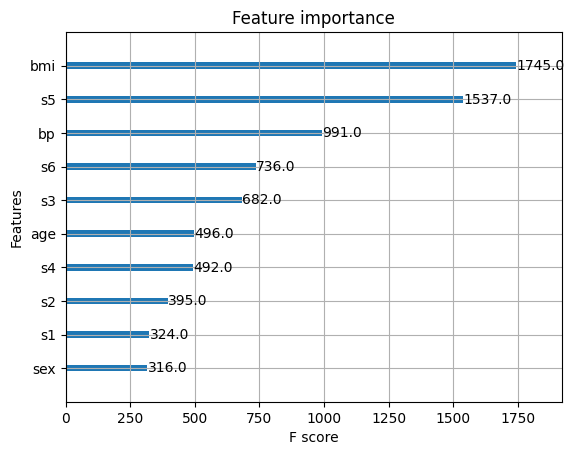

In [123]:
import graphviz
xgboost.plot_importance(model)

In [124]:
model.best_iteration

602

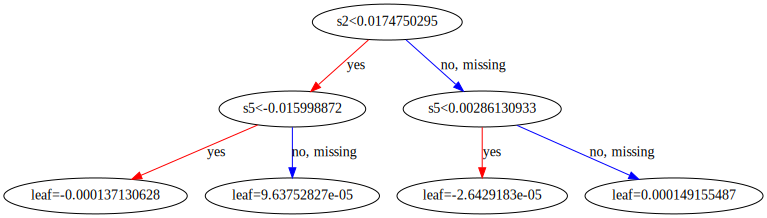

In [149]:
# converts the target tree to a graphviz instance
#xgboost.to_graphviz(model, num_trees=model.best_iteration)
xgboost.to_graphviz(model, num_trees=0)

In [126]:
predictions = model.predict(X_test)

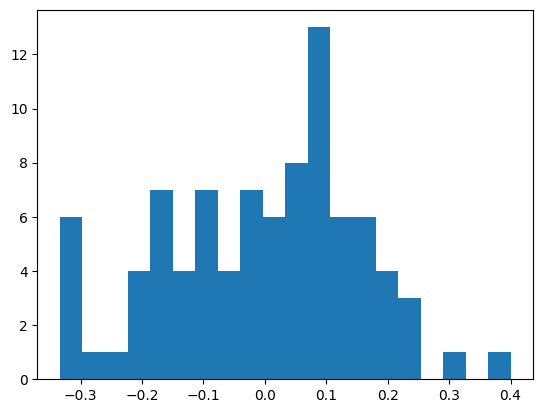

In [127]:
res = (predictions-y_test)
_= plt.hist(res,20)

Text(0, 0.5, 'valore predetto')

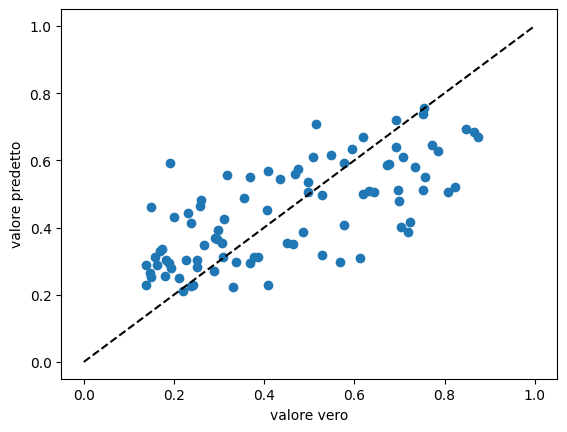

In [128]:
plt.scatter(y_test,predictions)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),"--",color="k")
plt.xlabel("valore vero")
plt.ylabel("valore predetto")

In [129]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(r2_score(y_test, predictions))

0.4926972273974336


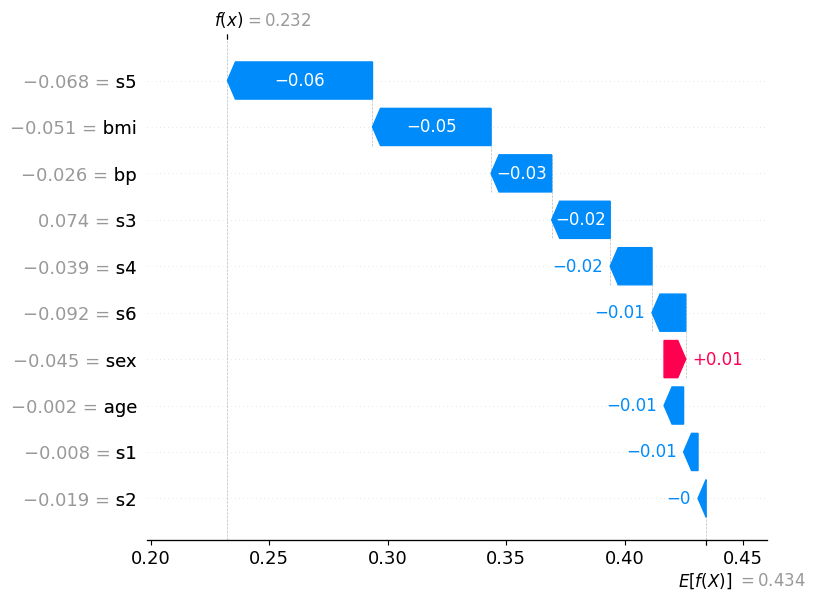

In [130]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[1])

In [131]:
# visualize all the training set predictions
shap.plots.initjs()
shap.plots.force(shap_values)



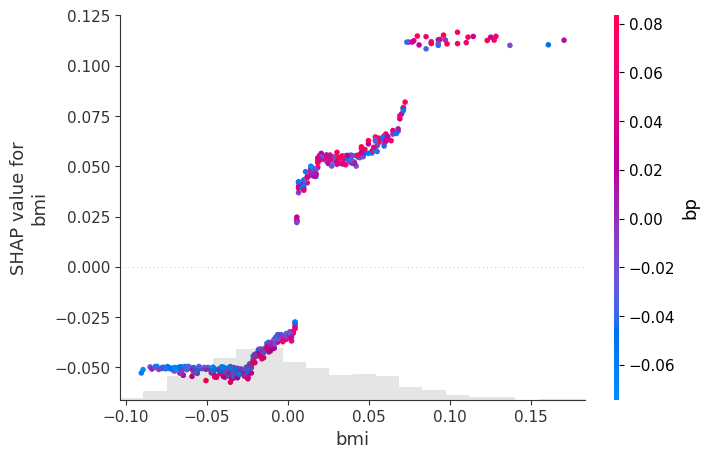

In [132]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "bmi"], color=shap_values)



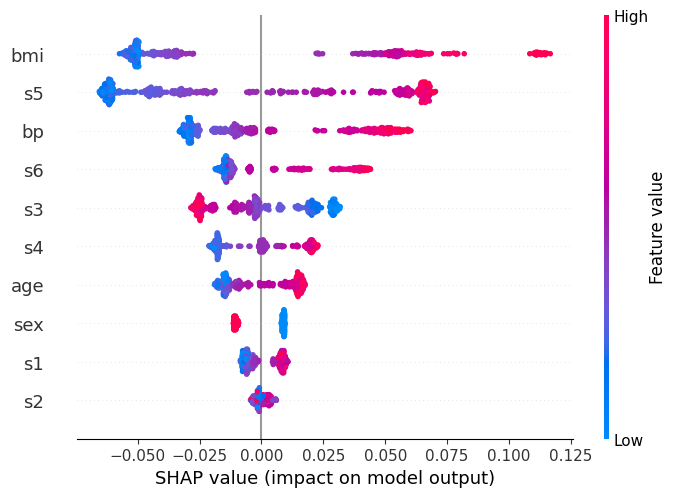

In [133]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)



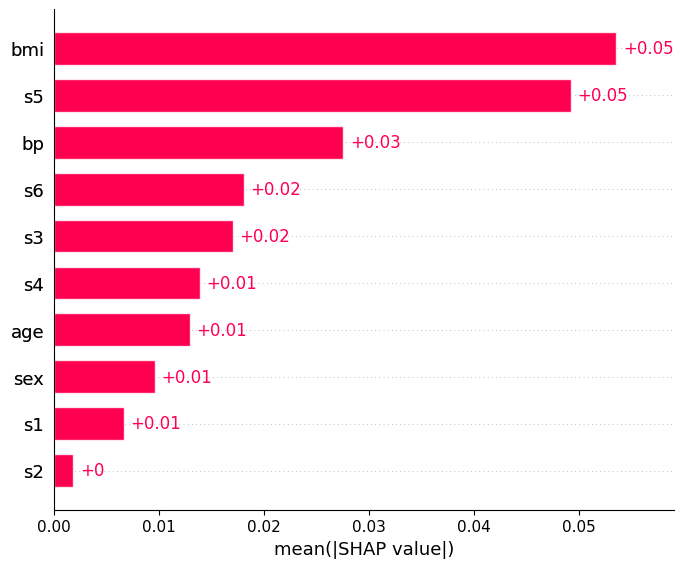

In [134]:
shap.plots.bar(shap_values)



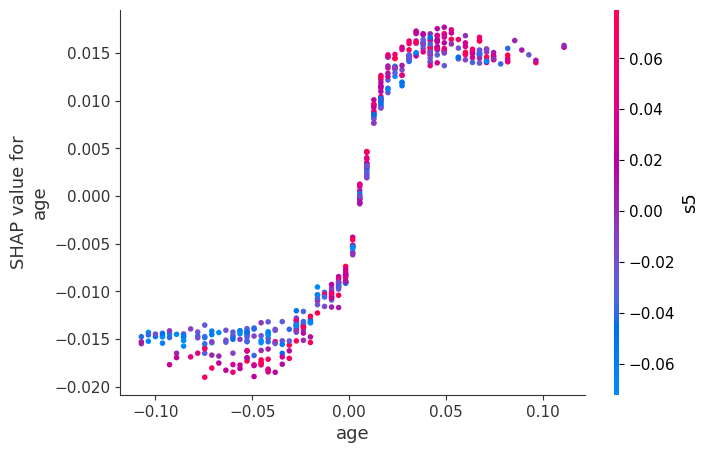

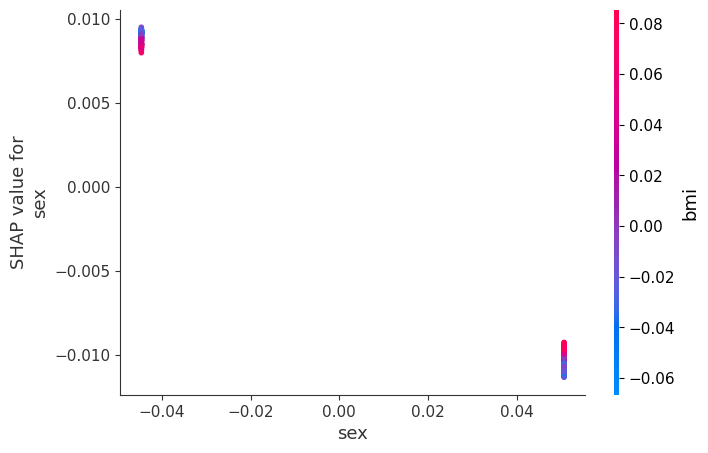

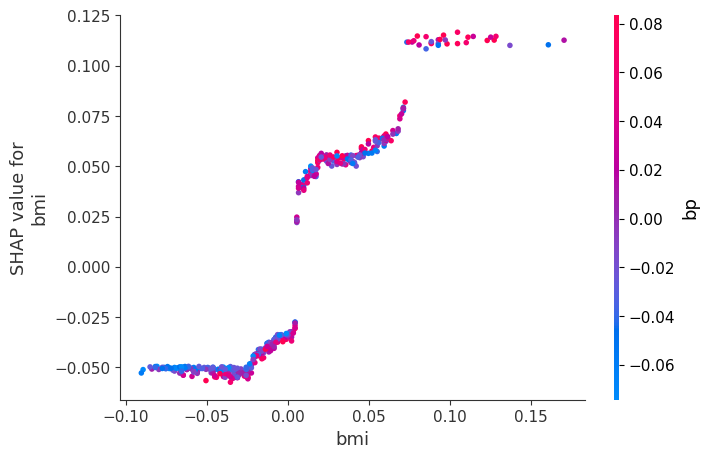

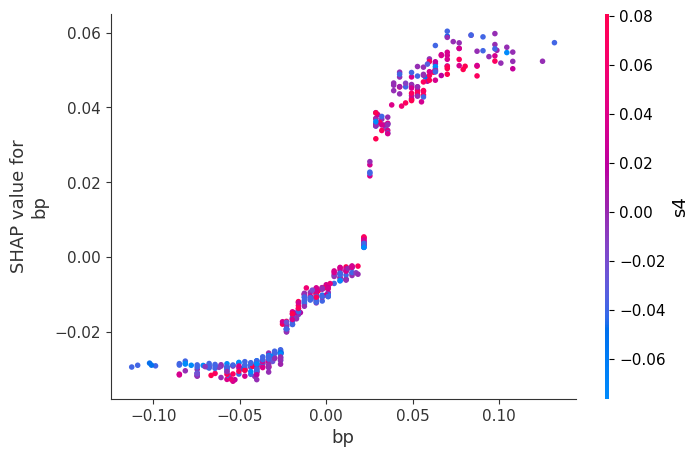

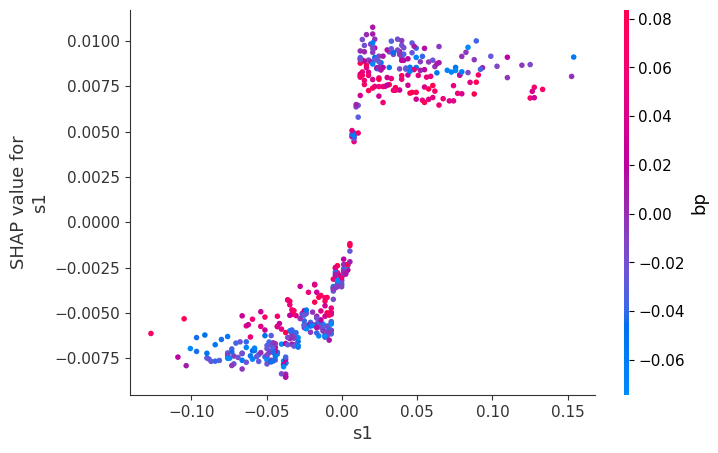

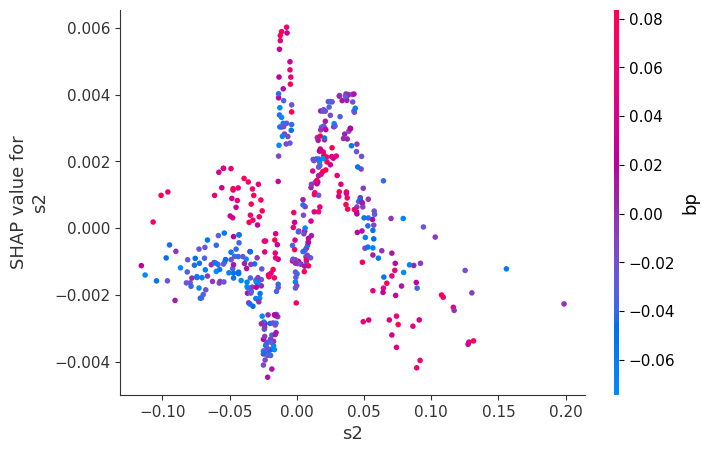

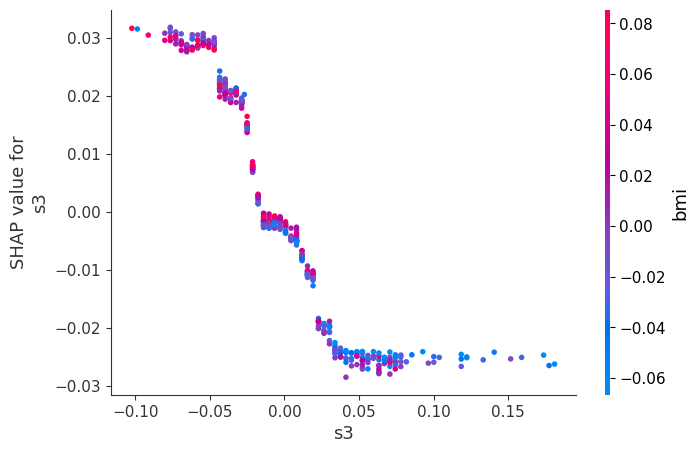

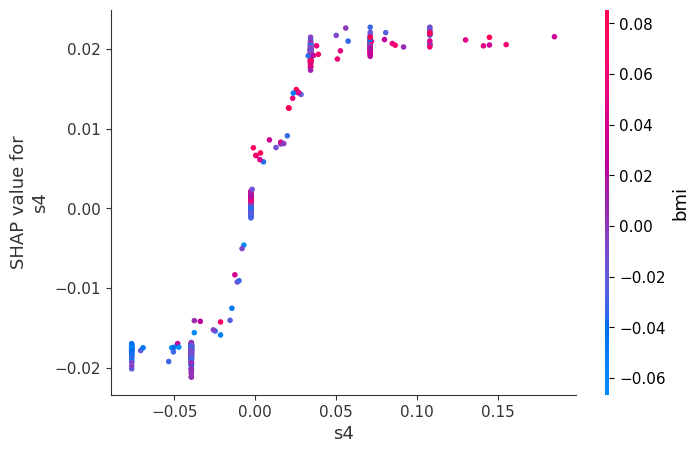

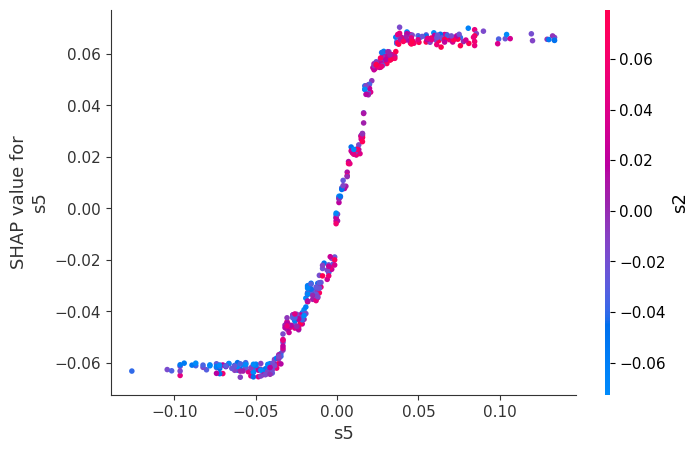

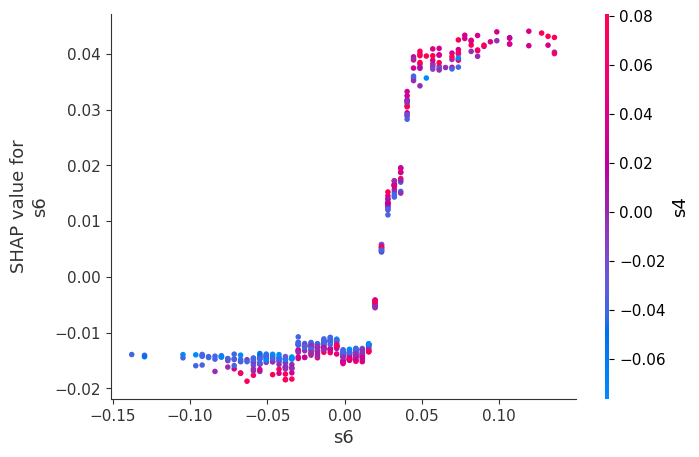

In [135]:
for name in X.columns:
    shap.dependence_plot(name, shap_values.values, X, display_features=X)